In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from cebra import CEBRA
from PIL import Image
import cv2
import torch
import pickle
import random
import os 
import itertools

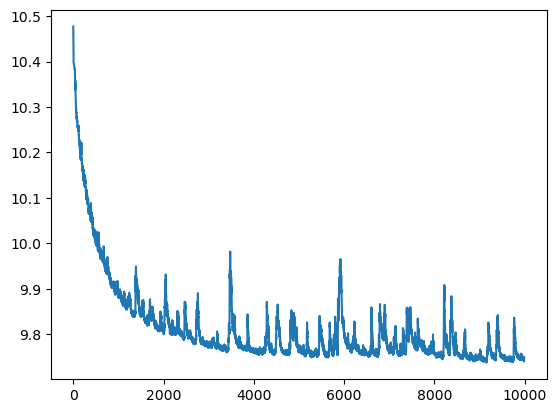

In [3]:
loss = torch.load('runs/checkpoint_0009990.pth')
loss = loss['loss']
plt.plot(loss)

In [ ]:

def process_brain(brain_seq):
  brain_seq = np.array(brain_seq)
  flat_seq = np.array([(brain_frame.flatten()) for brain_frame in brain_seq])
  return flat_seq.astype(float)

## Loads data from a folder of TIF files
# filepath: path to folder
# processor: function to process each image
# max: max images to load as a proportion of array size
# min: min images to load as a proportion of array size
# returns: list of processed images, list of filenames
def import_data(filepath, processor, min = 0, max = 1):
    output_data = []
    output_name = []
    path_list = os.listdir(filepath)
    path_list.sort()
    random.Random(4).shuffle(path_list)
    min_index = int(min * len(path_list))
    max_index = int(max * len(path_list))
    for file in itertools.islice(path_list, min_index, max_index):
     filename = os.fsdecode(file)
     if filename.endswith(".tif"):
         out = cv2.imreadmulti(filepath + '/' + filename)[1]
         output_data.append(processor(out))
         output_name.append(filename.split('.')[0])
     elif filename.endswith(".npy"):
         output_data.append(processor(np.load(filepath + '/' + filename)))
         output_name.append(filename.split('.')[0])
     else:
         continue
    return output_data, output_name

def flatten_data(data):
    return np.concatenate(data, axis=0)

def generate_CEBRA_embeddings(neural, model, session):
    embedding = []
    failed = []
    for run, data in enumerate(neural):
        embedding_data = [model[session].forward(torch.from_numpy((frame)).float().to(device).unsqueeze(0)).detach().cpu().numpy().squeeze() for frame in data] 
        embedding.append(embedding_data)
    return embedding

def load_model(model_path, model_name, output_dimension, hidden_units, input_size, model_number):
    #find available device
    device = torch.device('cuda:0')
    saved_model = torch.load(model_path)
    model = torch.nn.ModuleList([
        cebra.models.init(model_name, input_size,
                            hidden_units, output_dimension, True)
        for _ in range(model_number)
    ]).to(device)
    model.__setstate__(saved_model)
    model.eval()
    return model

def reshape_frames(frames, shape_ref):
    shape_list = [np.shape(x)[0] for x in shape_ref]
    gen_video_list = []
    index = 0
    for shape in shape_list:
        gen_video_list.append((frames[index : index + shape]))
        index += shape
    return gen_video_list

#choose a random window of set size from the data deterministically based on seed
def choose_random_window( window_size, seed, data):
    random.seed(seed)
    start = random.randint(0, len(data) - window_size)
    return data[start:start+window_size]


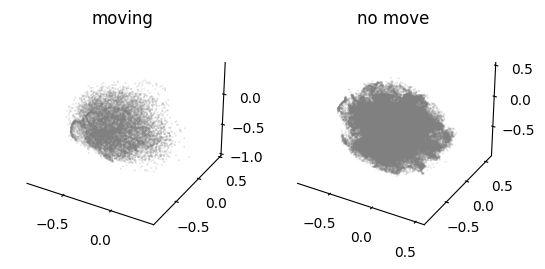

In [10]:

import cebra
fig = plt.figure()
move_nomove = []
ax1 = plt.subplot(121, projection='3d')
ax2 = plt.subplot(122, projection='3d')
index = 20
for run, data in enumerate(zip(neural_data, name_data)):
  is_move = True
  if data[1].split('_')[0] == 'move':
    is_move = True
    move_nomove.append(np.ones_like(data[0][:, 1]))
  else:
    is_move = False
    move_nomove.append(np.zeros_like(data[0][:, 1]))
  try:
    embedding = multi_cebra_model.transform(data[0], session_id=run)
  except:
    print(run)
    move_nomove.pop()
  if is_move:
    ax1 = cebra.plot_embedding(embedding, idx_order=(5,6, 7), ax=ax1, title='moving')
  else:
    ax2 = cebra.plot_embedding(embedding, ax=ax2, title = 'no move')

plt.show()

In [11]:
# split into training and validation set
move_nomove_train = move_nomove[:(int)(282 * 0.8)]
move_nomove_pred = move_nomove[225::]

In [12]:
move_embedding = []
for run, data in enumerate(neural_data):
  try:
    move_embedding.append(multi_cebra_model.transform(data, session_id=run))
  except:
    print(run)

In [13]:
embedding_train = move_embedding[:(int)(282 * 0.8)]
embedding_pred = move_embedding[225::]


In [14]:
def flatten_data(data):
    data_flat = np.squeeze(data[0])
    for x in data[1::]:
        data_flat = np.concatenate((data_flat, np.squeeze(x)))
    return data_flat

In [15]:
behav_feature_train = behav_feature[:(int)(282 * 0.8)]
behav_feature_flat = flatten_data(behav_feature_train)

In [16]:
move_embeddings_flat = flatten_data(embedding_train)
move_move_nomove_flat = flatten_data(move_nomove_train)


In [17]:
move_embeddings_flat_pred = flatten_data(embedding_pred)
move_move_nomove_flat_pred = flatten_data(move_nomove_pred)

In [18]:
print(np.shape(move_embeddings_flat))
print(np.shape(move_move_nomove_flat))
print(np.shape(move_embeddings_flat_pred))
print(np.shape(move_move_nomove_flat_pred))

(75952, 8)
(75952,)
(23296, 8)
(23296,)


In [19]:
import sklearn.metrics
move_decoder = cebra.KNNDecoder(n_neighbors=36, metric="cosine")
move_decoder.fit(move_embeddings_flat, move_move_nomove_flat)
move_pred = move_decoder.predict(move_embeddings_flat_pred)
test_score = sklearn.metrics.r2_score(move_move_nomove_flat_pred, move_pred)


In [ ]:
test_score

In [ ]:
proportion_move = print(np.sum(move_move_nomove_flat) / np.size(move_move_nomove_flat))

In [ ]:
predicted_labels = np.array(move_pred) > 0.5
true_labels = np.array(move_move_nomove_flat_pred)
#accuracy = print(np.sum(np.ones_like(move_pred) * ((np.array(move_pred) * np.array(move_move_nomove_flat_pred)) > 0.5)) / np.sum(move_move_nomove_flat_pred))


In [ ]:
matrix = sklearn.metrics.confusion_matrix(true_labels, predicted_labels)
disp = sklearn.metrics.ConfusionMatrixDisplay(matrix)
disp.plot()
plt.show()


In [ ]:
fig = plt.figure(figsize=(5,5))
ax = plt.subplot(111)

ax = cebra.plot_loss(multi_cebra_model, color='deepskyblue', label='loss', ax=ax)
plt.show()